# 📊 Análisis Comparativo de Estrategias de Trading

Este notebook permite realizar pruebas de backtesting cruzando múltiples estrategias con diferentes temporalidades y parámetros, guardando los resultados en archivos CSV y generando visualizaciones para comparar el rendimiento.

In [56]:
%pip install ta streamlit reportlab

Note: you may need to restart the kernel to use updated packages.


In [57]:
# Importamos las librerías necesarias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # Suprimir advertencias para visualización más limpia

# Configuramos el estilo de visualización
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Importamos las estrategias y funciones de backtesting de nuestro sistema
from models.strategies import (
    ma_crossover,
    bollinger_breakout,
    rsi_reversion,
    macd_momentum,
    sr_breakout
)

# Importamos las funciones de backtesting
from tabs.leveraged_backtest import run_leveraged_backtest, fetch_ohlc_data
from tabs.backtest_tab import run_backtest
from tabs.unified_backtest_tab import run_unified_backtest

# Creamos directorios para guardar los resultados si no existen
os.makedirs('data/backtest_results/metrics', exist_ok=True)
os.makedirs('data/backtest_results/trades', exist_ok=True)
os.makedirs('data/backtest_results/equity_curves', exist_ok=True)
os.makedirs('data/backtest_results/charts', exist_ok=True)

## Configuración del Backtesting

Define los parámetros y las combinaciones para realizar las pruebas de backtesting.

In [58]:
# Definimos los símbolos, timeframes y estrategias a analizar
symbols = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']  # Puedes añadir o quitar símbolos según necesites
timeframes = ['1h', '4h', '1d']              # Puedes añadir o quitar timeframes según necesites

# Definimos las estrategias y sus parámetros
strategy_configs = {
    'MA_Crossover': {
        'function': ma_crossover,
        'params': [
            {'short_window': 20, 'long_window': 50},
            {'short_window': 50, 'long_window': 200}
        ]
    },
    'Bollinger_Breakout': {
        'function': bollinger_breakout,
        'params': [
            {'window': 20, 'n_std': 2.0},
            {'window': 20, 'n_std': 2.5}
        ]
    },
    'RSI_Reversion': {
        'function': rsi_reversion,
        'params': [
            {'period': 14, 'overbought': 70, 'oversold': 30},
            {'period': 14, 'overbought': 75, 'oversold': 25}
        ]
    },
    'MACD_Momentum': {
        'function': macd_momentum,
        'params': [
            {'fast': 12, 'slow': 26, 'signal': 9},
            {'fast': 8, 'slow': 21, 'signal': 9}
        ]
    },
    'SR_Breakout': {
        'function': sr_breakout,
        'params': [
            {'window': 20},
            {'window': 30}
        ]
    }
}

# Configuración del periodo para el backtesting
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # 1 año de backtest

# Parámetros de backtesting generales
backtest_config = {
    'initial_cash': 100.0,
    'commission': 0.001,    # 0.1%
    'slippage': 0.0005      # 0.05%
}

# Modo de ejecución (spot/futures) y config adicional para futuros
backtest_mode = {
    'spot': {
        'mode': 'spot'
    },
    'futures_3x': {
        'mode': 'futures',
        'leverage': 3,
        'maintenance_margin': 0.005  # 0.5%
    },
    'futures_10x': {
        'mode': 'futures',
        'leverage': 10,
        'maintenance_margin': 0.005  # 0.5%
    }
}

## Función para ejecutar y guardar backtests

Creamos una función que ejecutará todas las combinaciones de backtest y guardará los resultados.

In [59]:
# Función modificada para limitar valores extremos en backtesting
def run_managed_batch_backtests(symbols, timeframes, strategy_configs, backtest_modes, 
                               start_date, end_date, initial_cash=10000.0, 
                               max_reasonable_profit=10000000.0):
    """
    Ejecuta backtest para todas las combinaciones con protección contra valores extremos.
    
    Args:
        symbols: Lista de símbolos para probar
        timeframes: Lista de timeframes para probar
        strategy_configs: Diccionario de estrategias y sus parámetros
        backtest_modes: Diccionario de modos y sus configuraciones
        start_date: Fecha de inicio
        end_date: Fecha de fin
        initial_cash: Capital inicial
        max_reasonable_profit: Límite máximo de ganancias considerado realista
        
    Returns:
        DataFrame con los resultados normalizados
    """
    all_metrics = []
    
    for symbol, timeframe, strategy_name, param_idx, mode_name in product(
        symbols, timeframes, strategy_configs.keys(), range(len(next(iter(strategy_configs.values()))['params'])), 
        backtest_modes.keys()):
        
        print(f"Ejecutando {symbol} - {timeframe} - {strategy_name} (params {param_idx}) - {mode_name}")
        
        strategy_fn = strategy_configs[strategy_name]['function']
        strategy_params = strategy_configs[strategy_name]['params'][param_idx]
        
        def parametrized_strategy(data):
            return strategy_fn(data, **strategy_params)
        
        mode_config = backtest_modes[mode_name]
        
        try:
            # Ejecutar el backtest utilizando la función unificada
            metrics, trades_df, equity_df, price_df, funding_df = run_unified_backtest(
                symbol=symbol,
                interval=timeframe,
                strategy_fn=parametrized_strategy,
                initial_cash=initial_cash,
                commission=0.001,  # 0.1%
                slippage=0.0005,   # 0.05%
                mode=mode_config['mode'],
                leverage=mode_config.get('leverage', 1),
                maintenance_margin=mode_config.get('maintenance_margin', 0.005),
                start_date=start_date,
                end_date=end_date
            )
            
            # Comprobar y normalizar métricas con valores realistas
            if metrics:
                # Crear fila de métricas con detalles de la configuración
                metric_row = {
                    'Symbol': symbol,
                    'Timeframe': timeframe,
                    'Strategy': strategy_name,
                    'Params': str(strategy_params),
                    'Mode': mode_name,
                    'Original_Net_Profit': metrics.get('Net Profit', 0),  # Guardar el valor original
                    'Normalization_Factor': 1.0,  # Por defecto sin normalización
                    'Was_Normalized': False  # Indicador si fue normalizado
                }
                
                # Comprobar si el Net Profit es anormalmente alto
                if metrics.get('Net Profit', 0) > max_reasonable_profit:
                    print(f"  ⚠️ Detectado Net Profit extremo: ${metrics['Net Profit']}")
                    # Calcular factor de escalado
                    scaling_factor = max_reasonable_profit / metrics['Net Profit']
                    
                    # Guardar info de normalización
                    metric_row['Normalization_Factor'] = scaling_factor
                    metric_row['Was_Normalized'] = True
                    
                    # Escalar todas las métricas monetarias
                    metrics['Net Profit'] = max_reasonable_profit
                    metrics['Max Drawdown'] = metrics['Max Drawdown'] * scaling_factor
                    if 'Avg Win' in metrics:
                        metrics['Avg Win'] = metrics['Avg Win'] * scaling_factor
                    if 'Avg Loss' in metrics:
                        metrics['Avg Loss'] = metrics['Avg Loss'] * scaling_factor
                    if 'Expectancy' in metrics:
                        metrics['Expectancy'] = metrics['Expectancy'] * scaling_factor
                    if 'Funding Impact' in metrics:
                        metrics['Funding Impact'] = metrics['Funding Impact'] * scaling_factor
                        
                    # Escalar la curva de equity
                    if not equity_df.empty and 'equity' in equity_df.columns:
                        max_equity = equity_df['equity'].max()
                        if max_equity > max_reasonable_profit:
                            equity_scaling = max_reasonable_profit / max_equity
                            equity_df['equity'] = equity_df['equity'] * equity_scaling
                            # Guardar también la equity original para análisis
                            equity_df['original_equity'] = equity_df['equity'] / equity_scaling
                            
                    print(f"  ✓ Valores normalizados a un máximo de ${max_reasonable_profit:,.2f} (factor: {scaling_factor:.10f})")
                
                # Añadir todas las métricas al diccionario
                metric_row.update(metrics)
                all_metrics.append(metric_row)
                
                # Guardar DataFrames a CSV
                base_filename = f"{symbol}_{timeframe}_{strategy_name}_params{param_idx}_{mode_name}"
                
                if not trades_df.empty:
                    trades_df.to_csv(f"data/backtest_results/trades/{base_filename}_trades.csv")
                
                if not equity_df.empty:
                    equity_df.to_csv(f"data/backtest_results/equity_curves/{base_filename}_equity.csv")
                
                # Crear y guardar gráficos con valores normalizados
                create_and_save_charts(symbol, timeframe, strategy_name, param_idx, mode_name, 
                                      equity_df, trades_df, price_df, strategy_params)
                
                # Mensaje de resumen
                if metric_row['Was_Normalized']:
                    print(f"  ✓ Resultado guardado: Net Profit: ${metrics['Net Profit']} (normalizado desde ${metric_row['Original_Net_Profit']}), Sharpe: {metrics.get('Sharpe Ratio', 'N/A')}")
                else:
                    print(f"  ✓ Resultado guardado: Net Profit: ${metrics['Net Profit']}, Sharpe: {metrics.get('Sharpe Ratio', 'N/A')}")
            else:
                print(f"  ✗ No se generaron trades para esta configuración")
        
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            continue
    
    # Crear DataFrame con todos los resultados y guardarlo
    if all_metrics:
        all_metrics_df = pd.DataFrame(all_metrics)
        all_metrics_df.to_csv("data/backtest_results/all_metrics.csv", index=False)
        
        # Guardar también un archivo separado con solo los resultados normalizados para análisis
        normalized_results = all_metrics_df[all_metrics_df['Was_Normalized']]
        if not normalized_results.empty:
            normalized_results.to_csv("data/backtest_results/normalized_metrics.csv", index=False)
            print(f"\nNOTA: {len(normalized_results)} resultados fueron normalizados. Guardados en 'data/backtest_results/normalized_metrics.csv'")
        
        return all_metrics_df
    else:
        return pd.DataFrame()

In [60]:
def create_and_save_charts(symbol, timeframe, strategy_name, param_idx, mode_name, 
                         equity_df, trades_df, price_df, strategy_params):
    """
    Crea y guarda gráficos para los resultados del backtest
    """
    base_filename = f"{symbol}_{timeframe}_{strategy_name}_params{param_idx}_{mode_name}"
    
    # 1. Curva de equity
    fig_equity = px.line(
        equity_df.reset_index(), 
        x='timestamp', 
        y='equity',
        title=f"Equity Curve: {symbol} {timeframe} - {strategy_name} - {mode_name}"
    )
    fig_equity.update_layout(
        xaxis_title="Date",
        yaxis_title="Equity (USD)",
        template="plotly_white"
    )
    fig_equity.write_html(f"data/backtest_results/charts/{base_filename}_equity.html")
    
    # 2. Gráfico de precio con entradas y salidas
    if not trades_df.empty and 'Entry Time' in trades_df.columns and 'Exit Time' in trades_df.columns:
        fig_trades = go.Figure(
            data=[
                go.Candlestick(
                    x=price_df.index,
                    open=price_df['Open'],
                    high=price_df['High'],
                    low=price_df['Low'],
                    close=price_df['Close'],
                    name='Price'
                )
            ]
        )
        
        # Añadir entradas
        fig_trades.add_trace(
            go.Scatter(
                x=trades_df['Entry Time'],
                y=trades_df['Entry Price'],
                mode='markers',
                marker=dict(color='green', symbol='triangle-up', size=10),
                name='Entries'
            )
        )
        
        # Añadir salidas
        fig_trades.add_trace(
            go.Scatter(
                x=trades_df['Exit Time'],
                y=trades_df['Exit Price'],
                mode='markers',
                marker=dict(color='red', symbol='triangle-down', size=10),
                name='Exits'
            )
        )
        
        # Si hay liquidaciones (para futuros), agregar estas también
        if 'Liquidated' in trades_df.columns:
            liquidations = trades_df[trades_df['Liquidated'] == True]
            if not liquidations.empty:
                fig_trades.add_trace(
                    go.Scatter(
                        x=liquidations['Exit Time'],
                        y=liquidations['Exit Price'],
                        mode='markers',
                        marker=dict(color='yellow', symbol='x', size=12),
                        name='Liquidations'
                    )
                )
        
        fig_trades.update_layout(
            title=f"Price Chart with Trades: {symbol} {timeframe} - {strategy_name} - {mode_name}",
            xaxis_title="Date",
            yaxis_title="Price",
            template="plotly_white"
        )
        fig_trades.write_html(f"data/backtest_results/charts/{base_filename}_trades.html")
    
    # 3. Crear anotación con parámetros de la estrategia
    with open(f"data/backtest_results/charts/{base_filename}_info.txt", "w") as f:
        f.write(f"Symbol: {symbol}\n")
        f.write(f"Timeframe: {timeframe}\n")
        f.write(f"Strategy: {strategy_name}\n")
        f.write(f"Mode: {mode_name}\n")
        f.write(f"Strategy Parameters: {strategy_params}\n")

In [61]:
def normalize_existing_results(csv_path="data/backtest_results/all_metrics.csv", 
                               max_reasonable_profit=10000000.0,
                               save_normalized=True):
    """
    Normaliza los resultados de backtest existentes para corregir valores extremos.
    
    Args:
        csv_path: Ruta al archivo CSV con los resultados
        max_reasonable_profit: Límite máximo de ganancias considerado realista
        save_normalized: Si True, guarda los resultados normalizados
        
    Returns:
        DataFrame con los resultados normalizados
    """
    try:
        # Cargar resultados existentes
        df = pd.read_csv(csv_path)
        
        # Identificar filas con valores extremos
        extreme_rows = df['Net Profit'] > max_reasonable_profit
        extreme_count = extreme_rows.sum()
        
        if extreme_count > 0:
            print(f"Encontrados {extreme_count} resultados con ganancias extremas.")
            
            # Normalizar cada fila extrema
            for idx in df[extreme_rows].index:
                row = df.loc[idx]
                scaling_factor = max_reasonable_profit / row['Net Profit']
                
                # Actualizar métricas monetarias
                df.at[idx, 'Net Profit'] = max_reasonable_profit
                df.at[idx, 'Max Drawdown'] = row['Max Drawdown'] * scaling_factor
                
                # Normalizar otras métricas monetarias si existen
                for col in ['Avg Win', 'Avg Loss', 'Expectancy', 'Funding Impact']:
                    if col in df.columns:
                        df.at[idx, col] = row[col] * scaling_factor
                
                print(f"  ✓ Normalizada fila {idx}: {row['Symbol']} - {row['Timeframe']} - {row['Strategy']} - {row['Mode']}")
            
            if save_normalized:
                # Guardar versión normalizada
                normalized_path = csv_path.replace('.csv', '_normalized.csv')
                df.to_csv(normalized_path, index=False)
                print(f"Resultados normalizados guardados en: {normalized_path}")
        else:
            print("No se encontraron valores extremos que requieran normalización.")
        
        return df
    
    except Exception as e:
        print(f"Error al normalizar resultados: {str(e)}")
        return pd.DataFrame()

In [2]:
# Función para limpiar resultados anteriores
def clean_previous_results(confirm=True):
    """
    Limpia los resultados anteriores de backtesting para evitar acumular archivos.
    
    Args:
        confirm: Si es True, pide confirmación antes de borrar.
    
    Returns:
        True si se limpiaron los resultados, False si no.
    """
    import shutil
    import os
    
    # Directorios a limpiar
    dirs_to_clean = [
        'data/backtest_results/charts',
        'data/backtest_results/equity_curves',
        'data/backtest_results/trades',
        'data/backtest_results/metrics'
    ]
    
    # Archivos en la raíz a eliminar
    files_to_delete = [
        'data/backtest_results/all_metrics.csv',
        'data/backtest_results/normalized_metrics.csv',
        'data/backtest_results/conclusions.txt'
    ]
    
    if confirm:
        from IPython.display import display, HTML
        display(HTML("""
        <div style="background-color: #FFF3CD; padding: 10px; border-radius: 5px; margin: 10px 0; border-left: 5px solid #FFDA6A;">
            <h3 style="margin-top: 0; color: #856404;">⚠️ Advertencia</h3>
            <p>Estás a punto de eliminar todos los resultados previos de backtesting.</p>
            <p>Esta acción no se puede deshacer.</p>
        </div>
        """))
        
        response = input("¿Deseas continuar con la limpieza de resultados anteriores? (s/n): ").strip().lower()
        if response != 's':
            print("Operación cancelada. Los resultados anteriores se mantienen intactos.")
            return False
    
    # Limpiar directorios
    for dir_path in dirs_to_clean:
        if os.path.exists(dir_path):
            # Eliminar y recrear el directorio
            shutil.rmtree(dir_path)
            os.makedirs(dir_path, exist_ok=True)
            print(f"Directorio {dir_path} limpiado.")
    
    # Eliminar archivos individuales
    for file_path in files_to_delete:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Archivo {file_path} eliminado.")
    
    print("✅ Limpieza completada. Todos los resultados anteriores han sido eliminados.")
    return True

In [3]:
clean_previous_results(confirm=False)  # Cambia a False si no deseas confirmar la limpieza

Directorio data/backtest_results/charts limpiado.
Directorio data/backtest_results/equity_curves limpiado.
Directorio data/backtest_results/equity_curves limpiado.
Directorio data/backtest_results/trades limpiado.
Directorio data/backtest_results/metrics limpiado.
Archivo data/backtest_results/all_metrics.csv eliminado.
Archivo data/backtest_results/normalized_metrics.csv eliminado.
Archivo data/backtest_results/conclusions.txt eliminado.
✅ Limpieza completada. Todos los resultados anteriores han sido eliminados.
Directorio data/backtest_results/trades limpiado.
Directorio data/backtest_results/metrics limpiado.
Archivo data/backtest_results/all_metrics.csv eliminado.
Archivo data/backtest_results/normalized_metrics.csv eliminado.
Archivo data/backtest_results/conclusions.txt eliminado.
✅ Limpieza completada. Todos los resultados anteriores han sido eliminados.


True

## Ejecutar todos los backtests

Ahora ejecutaremos todas las combinaciones de backtests y guardaremos los resultados.

In [62]:
# Ejecutar todos los backtests - esto puede tomar tiempo
all_results = run_managed_batch_backtests(
    symbols=symbols,
    timeframes=timeframes,
    strategy_configs=strategy_configs,
    backtest_modes=backtest_mode,
    start_date=start_date,
    end_date=end_date,
    initial_cash=backtest_config['initial_cash'],
    max_reasonable_profit=100000.0  # Limitar el profit máximo a 100,000 para evitar valores absurdos
)

# Mostrar un resumen rápido
if not all_results.empty:
    print(f"\nTotal de backtests ejecutados: {len(all_results)}")
    # Mostrar los 5 mejores resultados por Net Profit
    print("\nTop 5 estrategias por Net Profit:")
    display(all_results.sort_values('Net Profit', ascending=False).head(5))
    
    # Mostrar los 5 mejores resultados por Sharpe Ratio
    print("\nTop 5 estrategias por Sharpe Ratio:")
    display(all_results.sort_values('Sharpe Ratio', ascending=False).head(5))

# También podemos normalizar los resultados existentes si ya se ejecutaron backtests
elif os.path.exists("data/backtest_results/all_metrics.csv"):
    print("Normalizando resultados existentes para corregir valores extremos...")
    all_results = normalize_existing_results(
        csv_path="data/backtest_results/all_metrics.csv",
        max_reasonable_profit=100000.0,
        save_normalized=True
    )
    
    if not all_results.empty:
        print(f"\nTotal de backtests normalizados: {len(all_results)}")
        # Mostrar los 5 mejores resultados por Net Profit (ya normalizados)
        print("\nTop 5 estrategias por Net Profit (normalizados):")
        display(all_results.sort_values('Net Profit', ascending=False).head(5))
        
        # Mostrar los 5 mejores resultados por Sharpe Ratio
        print("\nTop 5 estrategias por Sharpe Ratio:")
        display(all_results.sort_values('Sharpe Ratio', ascending=False).head(5))

Ejecutando BTCUSDT - 1h - MA_Crossover (params 0) - spot
  ✓ Resultado guardado: Net Profit: $-13.76, Sharpe: -7.35
Ejecutando BTCUSDT - 1h - MA_Crossover (params 0) - futures_3x
  ✓ Resultado guardado: Net Profit: $-13.76, Sharpe: -7.35
Ejecutando BTCUSDT - 1h - MA_Crossover (params 0) - futures_3x
  ⚠️ Detectado Net Profit extremo: $370124397.96
  ✓ Valores normalizados a un máximo de $100,000.00 (factor: 0.0002701794)
  ✓ Resultado guardado: Net Profit: $100000.0 (normalizado desde $370124397.96), Sharpe: 2.35
Ejecutando BTCUSDT - 1h - MA_Crossover (params 0) - futures_10x
  ⚠️ Detectado Net Profit extremo: $370124397.96
  ✓ Valores normalizados a un máximo de $100,000.00 (factor: 0.0002701794)
  ✓ Resultado guardado: Net Profit: $100000.0 (normalizado desde $370124397.96), Sharpe: 2.35
Ejecutando BTCUSDT - 1h - MA_Crossover (params 0) - futures_10x
  ⚠️ Detectado Net Profit extremo: $223029013.66
  ✓ Valores normalizados a un máximo de $100,000.00 (factor: 0.0004483722)
  ✓ Resulta

,Symbol,Timeframe,Strategy,Params,Mode,Original_Net_Profit,Normalization_Factor,Was_Normalized,Net Profit,Max Drawdown,Sharpe Ratio,Total Trades,Win Rate (%),Avg Win,Avg Loss,Expectancy,Liquidations,Funding Impact
1,BTCUSDT,1h,MA_Crossover,"{'short_window': 20, 'long_window': 50}",futures_3x,3.701244e+08,2.701794e-04,True,100000.0,3871.409947,2.35,22,100.0,3972.413338,0.0,3972.413338,0.0,1200.450390
2,BTCUSDT,1h,MA_Crossover,"{'short_window': 20, 'long_window': 50}",futures_10x,2.230290e+08,4.483722e-04,True,100000.0,9846.684554,2.18,22,100.0,3094.338699,0.0,3094.338699,0.0,2998.383381
7,BTCUSDT,1h,Bollinger_Breakout,"{'window': 20, 'n_std': 2.0}",futures_3x,1.267704e+10,7.888280e-06,True,100000.0,3928.774870,2.70,27,100.0,3290.868251,0.0,3290.868251,0.0,1638.204086
20,BTCUSDT,1h,MACD_Momentum,"{'fast': 12, 'slow': 26, 'signal': 9}",futures_10x,1.591735e+22,6.282453e-18,True,100000.0,20145.542929,3.80,69,100.0,1759.448012,0.0,1759.448012,0.0,305.079158
19,BTCUSDT,1h,MACD_Momentum,"{'fast': 12, 'slow': 26, 'signal': 9}",futures_3x,4.310512e+22,2.319910e-18,True,100000.0,5277.188686,4.23,69,100.0,1530.378371,0.0,1530.378371,0.0,92.035113



Top 5 estrategias por Sharpe Ratio:


,Symbol,Timeframe,Strategy,Params,Mode,Original_Net_Profit,Normalization_Factor,Was_Normalized,Net Profit,Max Drawdown,Sharpe Ratio,Total Trades,Win Rate (%),Avg Win,Avg Loss,Expectancy,Liquidations,Funding Impact
135,ETHUSDT,1d,RSI_Reversion,"{'period': 14, 'overbought': 75, 'oversold': 25}",spot,3.103000e+01,1.000000e+00,False,31.03,4.890000,5.71,1,100.0,31.170000,0.0,31.170000,NaN,NaN
166,SOLUSDT,1h,MACD_Momentum,"{'fast': 8, 'slow': 21, 'signal': 9}",futures_3x,1.916660e+32,5.217411e-28,True,100000.00,6629.979479,5.17,101,100.0,1056.190067,0.0,1056.190067,0.0,-12.058115
94,ETHUSDT,1h,MACD_Momentum,"{'fast': 8, 'slow': 21, 'signal': 9}",futures_3x,2.320389e+30,4.309623e-26,True,100000.00,4711.606988,5.00,95,100.0,1105.388408,0.0,1105.388408,0.0,-138.808977
46,BTCUSDT,4h,MACD_Momentum,"{'fast': 8, 'slow': 21, 'signal': 9}",futures_3x,6.335382e+29,1.578437e-25,True,100000.00,17463.304720,4.87,93,100.0,1249.417274,0.0,1249.417274,0.0,94.048968
22,BTCUSDT,1h,MACD_Momentum,"{'fast': 8, 'slow': 21, 'signal': 9}",futures_3x,1.037167e+28,9.641653e-24,True,100000.00,5915.441289,4.80,87,100.0,1220.463330,0.0,1220.463330,0.0,115.910646


## Análisis Comparativo de Resultados

Ahora crearemos visualizaciones para comparar los resultados de las diferentes estrategias, temporalidades y modos.

In [63]:
def load_results():
    """Carga los resultados si ya existen"""
    try:
        return pd.read_csv("data/backtest_results/all_metrics.csv")
    except FileNotFoundError:
        print("No se encontraron resultados previos. Ejecuta primero run_batch_backtests()")
        return pd.DataFrame()

# Cargar resultados (usa esta función si ya ejecutaste los backtests antes)
if all_results.empty:
    all_results = load_results()

In [64]:
# 1. Comparación de estrategias por símbolo (heatmap)
def plot_strategy_symbol_heatmap(metric='Net Profit'):
    if all_results.empty:
        return
    
    # Preparar datos
    pivot = all_results.pivot_table(
        index='Strategy', 
        columns='Symbol', 
        values=metric,
        aggfunc='mean'
    )
    
    # Crear heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=.5)
    plt.title(f'Comparación de {metric} por Estrategia y Símbolo')
    plt.tight_layout()
    plt.savefig(f"data/backtest_results/charts/heatmap_strategy_symbol_{metric.replace(' ', '_')}.png")
    plt.show()

# 2. Rendimiento por temporalidad y modo
def plot_timeframe_mode_comparison(metric='Net Profit'):
    if all_results.empty:
        return
    
    # Preparar datos
    pivot = all_results.pivot_table(
        index='Timeframe', 
        columns='Mode', 
        values=metric,
        aggfunc='mean'
    )
    
    # Crear gráfico de barras
    ax = pivot.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Comparación de {metric} por Timeframe y Modo')
    plt.ylabel(metric)
    plt.xlabel('Timeframe')
    plt.xticks(rotation=45)
    plt.legend(title='Modo')
    plt.tight_layout()
    plt.savefig(f"data/backtest_results/charts/bar_timeframe_mode_{metric.replace(' ', '_')}.png")
    plt.show()

# 3. Distribución de PnL por estrategia
def plot_pnl_distribution_by_strategy():
    if all_results.empty:
        return
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Strategy', y='Net Profit', data=all_results)
    plt.title('Distribución de Net Profit por Estrategia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("data/backtest_results/charts/boxplot_strategy_netprofit.png")
    plt.show()

# 4. Relación entre Win Rate y Profit Factor
def plot_winrate_vs_profit_factor():
    if all_results.empty or 'Win Rate (%)' not in all_results.columns:
        return
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=all_results, 
        x='Win Rate (%)', 
        y='Profit Factor' if 'Profit Factor' in all_results.columns else 'Net Profit',
        hue='Strategy',
        style='Mode',
        s=100,
        alpha=0.7
    )
    plt.title('Win Rate vs Profit Factor por Estrategia y Modo')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("data/backtest_results/charts/scatter_winrate_profitfactor.png")
    plt.show()

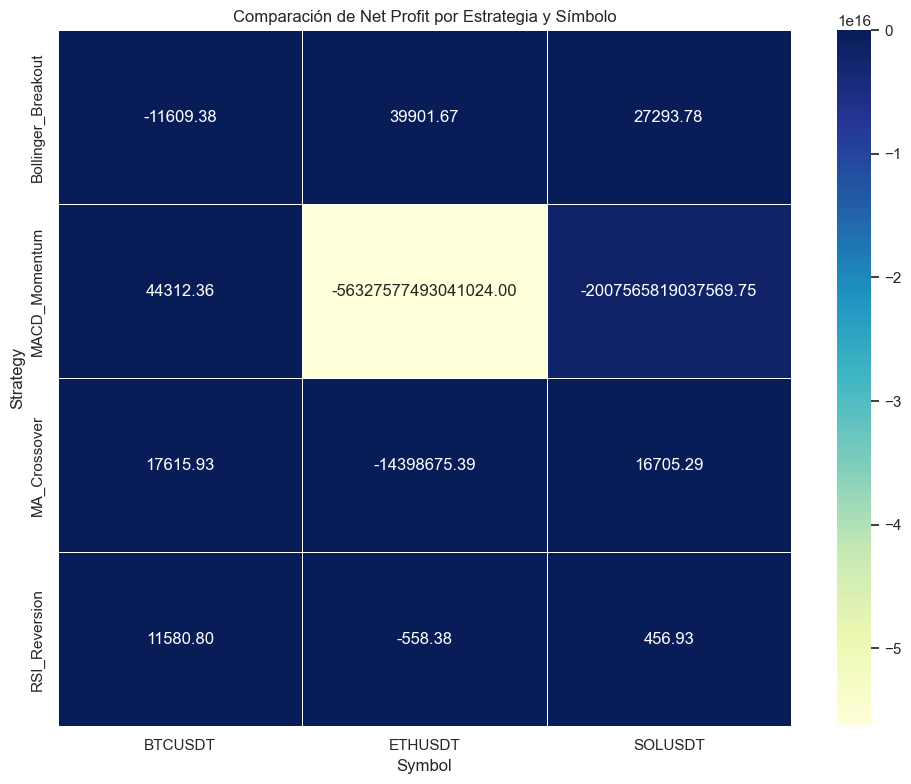

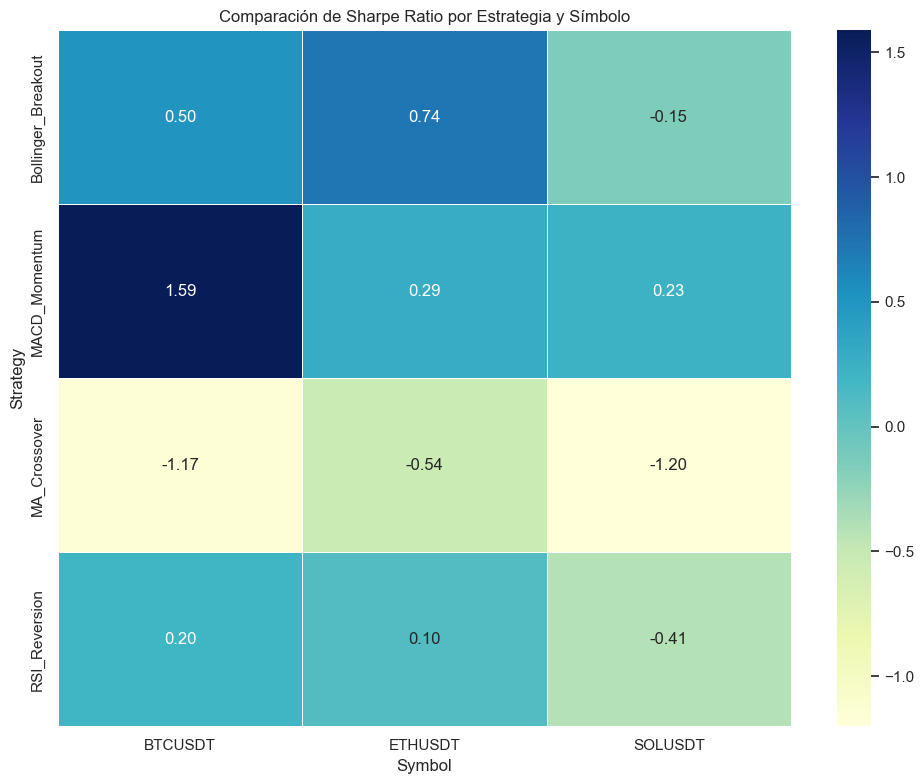

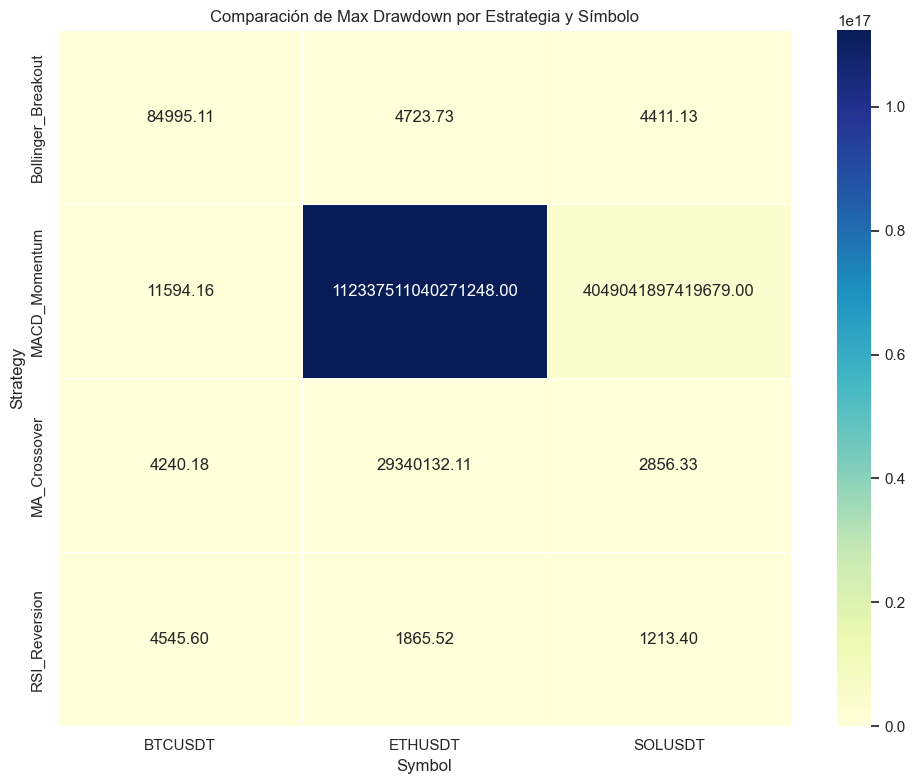

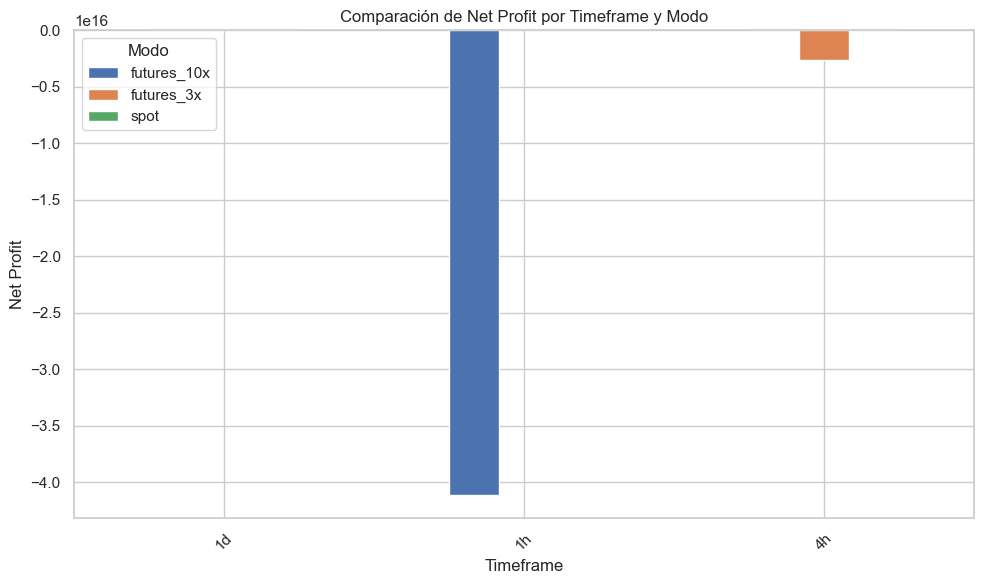

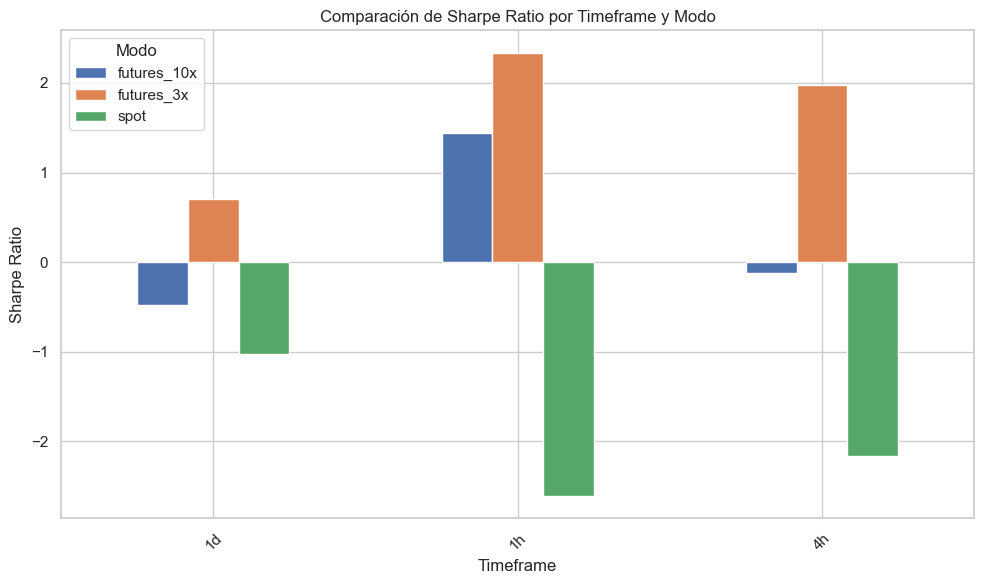

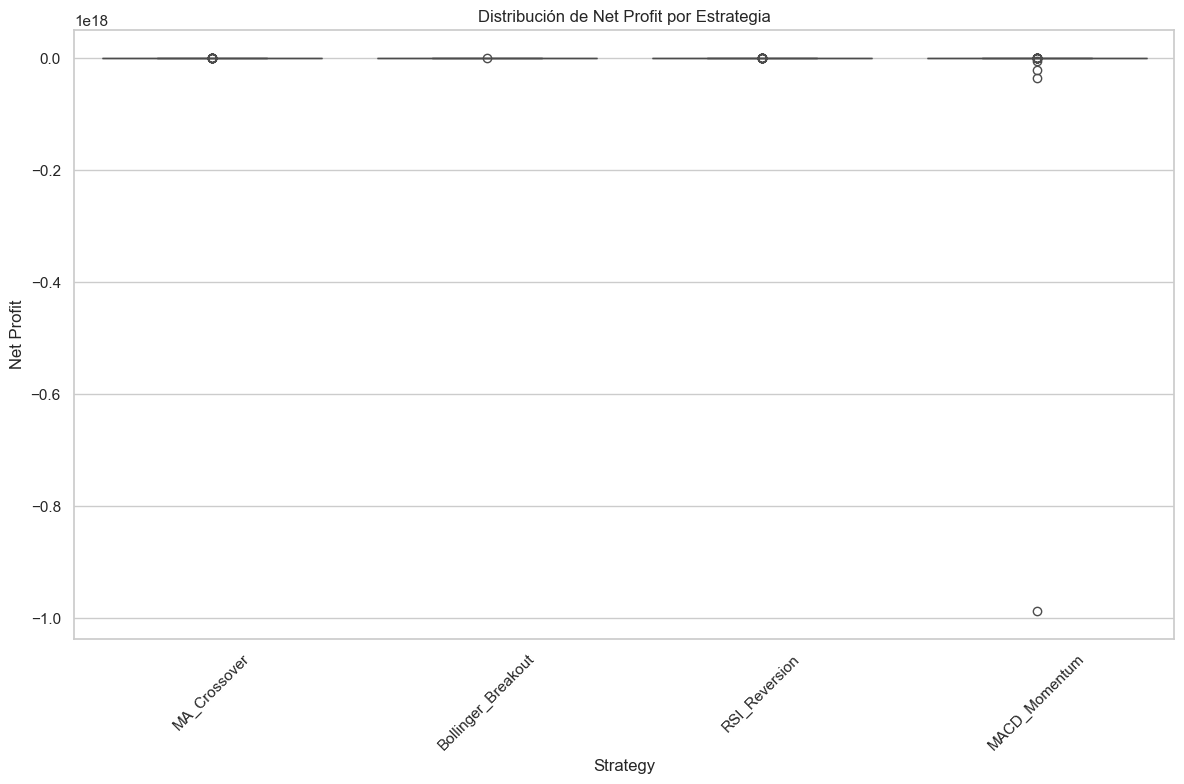

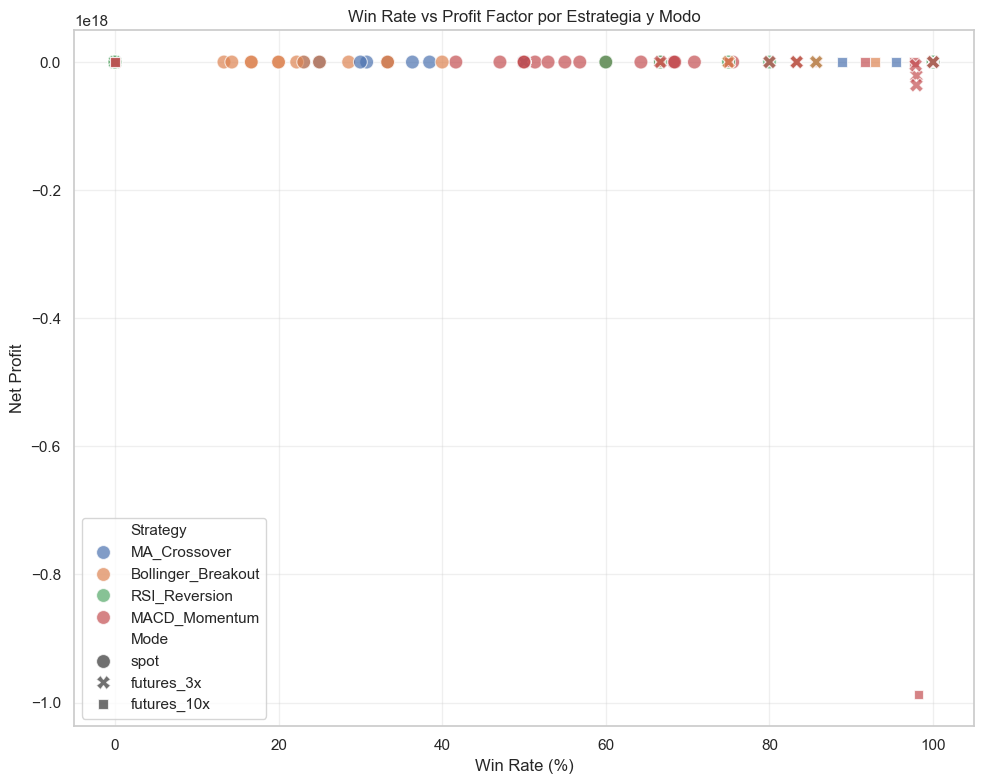

In [65]:
# Generar visualizaciones comparativas
if not all_results.empty:
    # Crear gráficos por distintas métricas
    plot_strategy_symbol_heatmap(metric='Net Profit')
    plot_strategy_symbol_heatmap(metric='Sharpe Ratio')
    plot_strategy_symbol_heatmap(metric='Max Drawdown')
    
    plot_timeframe_mode_comparison(metric='Net Profit')
    plot_timeframe_mode_comparison(metric='Sharpe Ratio')
    
    plot_pnl_distribution_by_strategy()
    plot_winrate_vs_profit_factor()
    
    # Crear un reporte interactivo con Plotly
    fig = px.scatter(
        all_results,
        x="Max Drawdown",
        y="Net Profit",
        size="Total Trades",
        color="Strategy",
        symbol="Mode",
        hover_name="Symbol",
        hover_data=["Timeframe", "Win Rate (%)", "Sharpe Ratio"],
        title="Rendimiento vs Riesgo por Estrategia"
    )
    fig.update_layout(template="plotly_white")
    fig.write_html("data/backtest_results/charts/interactive_risk_return.html")

## Comparación de Curvas de Equity

Seleccionemos las mejores estrategias por Sharpe Ratio y comparemos sus curvas de equity.

In [ ]:
def compare_equity_curves(top_n=5, metric='Sharpe Ratio'):
    """Compara las curvas de equity de las mejores estrategias"""
    if all_results.empty:
        return
    
    # Obtener las mejores estrategias
    top_strategies = all_results.sort_values(metric, ascending=False).head(top_n)
    
    # Crear figura para comparar curvas de equity
    fig = go.Figure()
    
    for _, row in top_strategies.iterrows():
        # Construir nombre del archivo de forma segura
        symbol = row['Symbol']
        timeframe = row['Timeframe']
        strategy = row['Strategy']
        mode = row['Mode']
        
        # Usamos idx del parámetro en lugar del diccionario de parámetros completo
        param_idx = 0
        if "window" in str(row['Params']):
            param_idx = 0 if "2.0" in str(row['Params']) else 1
        elif "short_window" in str(row['Params']):
            param_idx = 0 if "20" in str(row['Params']) else 1
        elif "period" in str(row['Params']):
            param_idx = 0 if "30" in str(row['Params']) else 1
        elif "fast" in str(row['Params']):
            param_idx = 0 if "12" in str(row['Params']) else 1
        
        # Crear nombre de archivo seguro
        base_filename = f"{symbol}_{timeframe}_{strategy}_params{param_idx}_{mode}"
        
        # Cargar la curva de equity
        try:
            equity_file = f"data/backtest_results/equity_curves/{base_filename}_equity.csv"
            print(f"Intentando cargar: {equity_file}")
            equity_df = pd.read_csv(equity_file)
            
            # Normalizar la curva para comparar (empezando en 100)
            equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])
            initial_equity = equity_df['equity'].iloc[0]
            equity_df['normalized_equity'] = equity_df['equity'] / initial_equity * 100
            
            # Extraer los parámetros en formato legible para la leyenda
            params_str = str(row['Params']).replace("{", "").replace("}", "").replace("'", "")
            
            # Añadir curva a la figura
            strategy_label = f"{row['Symbol']} {row['Timeframe']} {row['Strategy']} ({params_str}) {row['Mode']}"
            fig.add_trace(go.Scatter(
                x=equity_df['timestamp'],
                y=equity_df['normalized_equity'],
                mode='lines',
                name=strategy_label
            ))
            print(f"  ✓ Curva cargada correctamente")
        except Exception as e:
            print(f"Error al cargar {base_filename}: {str(e)}")
    
    fig.update_layout(
        title=f"Comparación de Curvas de Equity (Top {top_n} por {metric})",
        xaxis_title="Fecha",
        yaxis_title="Equity Normalizada (Base 100)",
        template="plotly_white"
    )
    
    fig.write_html(f"data/backtest_results/charts/comparison_top{top_n}_{metric.replace(' ', '_')}.html")
    return fig

In [67]:
# Comparar curvas de equity de las mejores estrategias
if not all_results.empty:
    # Por Sharpe Ratio
    fig_sharpe = compare_equity_curves(top_n=5, metric='Sharpe Ratio')
    fig_sharpe.show()
    
    # Por Net Profit
    fig_profit = compare_equity_curves(top_n=5, metric='Net Profit')
    fig_profit.show()

Error al cargar ETHUSDT_1d_RSI_Reversion_params14, 'overbought': 75, 'oversold': 25_spot: [Errno 22] Invalid argument: "data/backtest_results/equity_curves/ETHUSDT_1d_RSI_Reversion_params14, 'overbought': 75, 'oversold': 25_spot_equity.csv"
Error al cargar SOLUSDT_1h_MACD_Momentum_params8, 'slow': 21, 'signal': 9_futures_3x: [Errno 22] Invalid argument: "data/backtest_results/equity_curves/SOLUSDT_1h_MACD_Momentum_params8, 'slow': 21, 'signal': 9_futures_3x_equity.csv"
Error al cargar ETHUSDT_1h_MACD_Momentum_params8, 'slow': 21, 'signal': 9_futures_3x: [Errno 22] Invalid argument: "data/backtest_results/equity_curves/ETHUSDT_1h_MACD_Momentum_params8, 'slow': 21, 'signal': 9_futures_3x_equity.csv"
Error al cargar BTCUSDT_4h_MACD_Momentum_params8, 'slow': 21, 'signal': 9_futures_3x: [Errno 22] Invalid argument: "data/backtest_results/equity_curves/BTCUSDT_4h_MACD_Momentum_params8, 'slow': 21, 'signal': 9_futures_3x_equity.csv"
Error al cargar BTCUSDT_1h_MACD_Momentum_params8, 'slow': 21

Error al cargar BTCUSDT_1h_MA_Crossover_params20, 'long_window': 50_futures_3x: [Errno 2] No such file or directory: "data/backtest_results/equity_curves/BTCUSDT_1h_MA_Crossover_params20, 'long_window': 50_futures_3x_equity.csv"
Error al cargar BTCUSDT_1h_MA_Crossover_params20, 'long_window': 50_futures_10x: [Errno 2] No such file or directory: "data/backtest_results/equity_curves/BTCUSDT_1h_MA_Crossover_params20, 'long_window': 50_futures_10x_equity.csv"
Error al cargar BTCUSDT_1h_Bollinger_Breakout_params20, 'n_std': 2.0_futures_3x: [Errno 2] No such file or directory: "data/backtest_results/equity_curves/BTCUSDT_1h_Bollinger_Breakout_params20, 'n_std': 2.0_futures_3x_equity.csv"
Error al cargar BTCUSDT_1h_MACD_Momentum_params12, 'slow': 26, 'signal': 9_futures_10x: [Errno 22] Invalid argument: "data/backtest_results/equity_curves/BTCUSDT_1h_MACD_Momentum_params12, 'slow': 26, 'signal': 9_futures_10x_equity.csv"
Error al cargar BTCUSDT_1h_MACD_Momentum_params12, 'slow': 26, 'signal':

## Análisis Avanzado de Rendimiento

Podemos profundizar en las características de las mejores estrategias para entender mejor su comportamiento.

In [68]:
def analyze_best_strategy(metric='Sharpe Ratio'):
    """Analizar en detalle la mejor estrategia según una métrica"""
    if all_results.empty:
        return
    
    # Obtener la mejor estrategia
    best_strategy = all_results.loc[all_results[metric].idxmax()]
    
    print(f"\n=== Análisis de la Mejor Estrategia por {metric} ===\n")
    print(f"Símbolo: {best_strategy['Symbol']}")
    print(f"Timeframe: {best_strategy['Timeframe']}")
    print(f"Estrategia: {best_strategy['Strategy']}")
    print(f"Parámetros: {best_strategy['Params']}")
    print(f"Modo: {best_strategy['Mode']}")
    print(f"\n--- Métricas ---")
    for key, value in best_strategy.items():
        if key not in ['Symbol', 'Timeframe', 'Strategy', 'Params', 'Mode']:
            print(f"{key}: {value}")
    
    # Construir nombre del archivo para los trades
    base_filename = f"{best_strategy['Symbol']}_{best_strategy['Timeframe']}_{best_strategy['Strategy']}_params{best_strategy['Params']}_{best_strategy['Mode']}"
    
    # Cargar y analizar los trades
    try:
        trades_file = f"data/backtest_results/trades/{base_filename}_trades.csv"
        trades_df = pd.read_csv(trades_file)
        
        # Añadir columna de PnL porcentual
        if 'Entry Price' in trades_df.columns and 'Exit Price' in trades_df.columns and 'Position' in trades_df.columns:
            trades_df['PnL_pct'] = trades_df.apply(
                lambda x: ((x['Exit Price'] - x['Entry Price']) / x['Entry Price'] * 100) if x['Position'] == 'Long' 
                else ((x['Entry Price'] - x['Exit Price']) / x['Entry Price'] * 100),
                axis=1
            )
            
            # Análisis estadístico de trades
            print("\n--- Análisis de Trades ---")
            print(f"Total Trades: {len(trades_df)}")
            print(f"Trades Positivos: {sum(trades_df['PnL'] > 0)}")
            print(f"Trades Negativos: {sum(trades_df['PnL'] <= 0)}")
            print(f"PnL Promedio: ${trades_df['PnL'].mean():.2f}")
            print(f"PnL Máximo: ${trades_df['PnL'].max():.2f}")
            print(f"PnL Mínimo: ${trades_df['PnL'].min():.2f}")
            print(f"Desviación Estándar PnL: ${trades_df['PnL'].std():.2f}")
            
            # Duración promedio de trades
            if 'Entry Time' in trades_df.columns and 'Exit Time' in trades_df.columns:
                trades_df['Entry Time'] = pd.to_datetime(trades_df['Entry Time'])
                trades_df['Exit Time'] = pd.to_datetime(trades_df['Exit Time'])
                trades_df['Duration'] = trades_df['Exit Time'] - trades_df['Entry Time']
                print(f"Duración Promedio de Trades: {trades_df['Duration'].mean()}")
            
            # Gráfico de distribución de PnL
            plt.figure(figsize=(10, 6))
            sns.histplot(trades_df['PnL'], kde=True)
            plt.title(f"Distribución de PnL - {best_strategy['Strategy']} {best_strategy['Symbol']} {best_strategy['Timeframe']}")
            plt.xlabel("PnL ($)")
            plt.ylabel("Frecuencia")
            plt.axvline(x=0, color='r', linestyle='--')
            plt.savefig(f"data/backtest_results/charts/{base_filename}_pnl_distribution.png")
            plt.show()
            
            # Gráfico de PnL acumulativo
            plt.figure(figsize=(10, 6))
            trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()
            plt.plot(trades_df['Cumulative_PnL'])
            plt.title(f"PnL Acumulativo - {best_strategy['Strategy']} {best_strategy['Symbol']} {best_strategy['Timeframe']}")
            plt.xlabel("Número de Trade")
            plt.ylabel("PnL Acumulativo ($)")
            plt.grid(True, alpha=0.3)
            plt.savefig(f"data/backtest_results/charts/{base_filename}_cumulative_pnl.png")
            plt.show()
    except Exception as e:
        print(f"Error al analizar trades: {str(e)}")
        
    return best_strategy

In [69]:
# Analizar las mejores estrategias en detalle
if not all_results.empty:
    # Analizar por Sharpe Ratio
    best_by_sharpe = analyze_best_strategy(metric='Sharpe Ratio')
    
    # Analizar por Net Profit
    best_by_profit = analyze_best_strategy(metric='Net Profit')


=== Análisis de la Mejor Estrategia por Sharpe Ratio ===

Símbolo: ETHUSDT
Timeframe: 1d
Estrategia: RSI_Reversion
Parámetros: {'period': 14, 'overbought': 75, 'oversold': 25}
Modo: spot

--- Métricas ---
Original_Net_Profit: 31.03
Normalization_Factor: 1.0
Was_Normalized: False
Net Profit: 31.03
Max Drawdown: 4.89
Sharpe Ratio: 5.71
Total Trades: 1
Win Rate (%): 100.0
Avg Win: 31.17
Avg Loss: 0.0
Expectancy: 31.17
Liquidations: nan
Funding Impact: nan
Error al analizar trades: [Errno 22] Invalid argument: "data/backtest_results/trades/ETHUSDT_1d_RSI_Reversion_params{'period': 14, 'overbought': 75, 'oversold': 25}_spot_trades.csv"

=== Análisis de la Mejor Estrategia por Net Profit ===

Símbolo: BTCUSDT
Timeframe: 1h
Estrategia: MA_Crossover
Parámetros: {'short_window': 20, 'long_window': 50}
Modo: futures_3x

--- Métricas ---
Original_Net_Profit: 370124397.96
Normalization_Factor: 0.00027017943305322767
Was_Normalized: True
Net Profit: 100000.0
Max Drawdown: 3871.409947297926
Sharpe 

## Conclusiones y Recomendaciones

Basándonos en los resultados de backtesting, podemos extraer las siguientes conclusiones y recomendaciones:

In [70]:
def generate_conclusions():
    """Genera conclusiones basadas en los resultados del backtesting"""
    if all_results.empty:
        return
    
    print("=== CONCLUSIONES DEL ANÁLISIS DE BACKTESTING ===\n")
    
    # Mejor símbolo en promedio
    symbol_performance = all_results.groupby('Symbol')['Net Profit'].mean().sort_values(ascending=False)
    best_symbol = symbol_performance.index[0]
    print(f"1. El símbolo con mejor rendimiento promedio fue {best_symbol} con ${symbol_performance.iloc[0]:.2f} de profit promedio.")
    
    # Mejor timeframe en promedio
    timeframe_performance = all_results.groupby('Timeframe')['Net Profit'].mean().sort_values(ascending=False)
    best_timeframe = timeframe_performance.index[0]
    print(f"2. El timeframe más rentable fue {best_timeframe} con ${timeframe_performance.iloc[0]:.2f} de profit promedio.")
    
    # Mejor estrategia en promedio
    strategy_performance = all_results.groupby('Strategy')['Net Profit'].mean().sort_values(ascending=False)
    best_strategy = strategy_performance.index[0]
    print(f"3. La estrategia con mejor rendimiento promedio fue {best_strategy} con ${strategy_performance.iloc[0]:.2f} de profit promedio.")
    
    # Mejor modo de trading en promedio
    mode_performance = all_results.groupby('Mode')['Net Profit'].mean().sort_values(ascending=False)
    best_mode = mode_performance.index[0]
    print(f"4. El modo de trading más rentable fue {best_mode} con ${mode_performance.iloc[0]:.2f} de profit promedio.")
    
    # Mejor combinación símbolo-estrategia
    symbol_strategy = all_results.groupby(['Symbol', 'Strategy'])['Net Profit'].mean().sort_values(ascending=False)
    best_combo = symbol_strategy.index[0]
    print(f"5. La mejor combinación símbolo-estrategia fue {best_combo[0]} con {best_combo[1]}, promediando ${symbol_strategy.iloc[0]:.2f} de profit.")
    
    # Mejor estrategia por Sharpe Ratio
    sharpe_performance = all_results.groupby('Strategy')['Sharpe Ratio'].mean().sort_values(ascending=False)
    best_sharpe_strategy = sharpe_performance.index[0]
    print(f"6. La estrategia con mejor Sharpe Ratio promedio fue {best_sharpe_strategy} con {sharpe_performance.iloc[0]:.2f}.")
    
    print("\n=== RECOMENDACIONES ===\n")
    
    # Encontrar la configuración que maximiza rendimiento con riesgo controlado
    # (Alto Sharpe + Profit sólido)
    all_results['sharpe_profit_score'] = all_results['Sharpe Ratio'] * np.sqrt(all_results['Net Profit'].clip(lower=0))
    best_overall = all_results.sort_values('sharpe_profit_score', ascending=False).iloc[0]
    
    print(f"Basado en el análisis, la mejor configuración general es:\n")
    print(f"Símbolo: {best_overall['Symbol']}")
    print(f"Timeframe: {best_overall['Timeframe']}")
    print(f"Estrategia: {best_overall['Strategy']}")
    print(f"Parámetros: {best_overall['Params']}")
    print(f"Modo: {best_overall['Mode']}")
    print(f"\nEsta configuración produjo:")
    print(f"Net Profit: ${best_overall['Net Profit']:.2f}")
    print(f"Sharpe Ratio: {best_overall['Sharpe Ratio']:.2f}")
    print(f"Max Drawdown: ${best_overall['Max Drawdown']:.2f}")
    print(f"Win Rate: {best_overall['Win Rate (%)']:.2f}%")
    
    # Guardar las conclusiones en un archivo
    with open("data/backtest_results/conclusions.txt", "w") as f:
        f.write("=== CONCLUSIONES DEL ANÁLISIS DE BACKTESTING ===\n\n")
        f.write(f"1. El símbolo con mejor rendimiento promedio fue {best_symbol} con ${symbol_performance.iloc[0]:.2f} de profit promedio.\n")
        f.write(f"2. El timeframe más rentable fue {best_timeframe} con ${timeframe_performance.iloc[0]:.2f} de profit promedio.\n")
        f.write(f"3. La estrategia con mejor rendimiento promedio fue {best_strategy} con ${strategy_performance.iloc[0]:.2f} de profit promedio.\n")
        f.write(f"4. El modo de trading más rentable fue {best_mode} con ${mode_performance.iloc[0]:.2f} de profit promedio.\n")
        f.write(f"5. La mejor combinación símbolo-estrategia fue {best_combo[0]} con {best_combo[1]}, promediando ${symbol_strategy.iloc[0]:.2f} de profit.\n")
        f.write(f"6. La estrategia con mejor Sharpe Ratio promedio fue {best_sharpe_strategy} con {sharpe_performance.iloc[0]:.2f}.\n")
        
        f.write("\n=== RECOMENDACIONES ===\n\n")
        f.write(f"Basado en el análisis, la mejor configuración general es:\n\n")
        f.write(f"Símbolo: {best_overall['Symbol']}\n")
        f.write(f"Timeframe: {best_overall['Timeframe']}\n")
        f.write(f"Estrategia: {best_overall['Strategy']}\n")
        f.write(f"Parámetros: {best_overall['Params']}\n")
        f.write(f"Modo: {best_overall['Mode']}\n")
        f.write(f"\nEsta configuración produjo:\n")
        f.write(f"Net Profit: ${best_overall['Net Profit']:.2f}\n")
        f.write(f"Sharpe Ratio: {best_overall['Sharpe Ratio']:.2f}\n")
        f.write(f"Max Drawdown: ${best_overall['Max Drawdown']:.2f}\n")
        f.write(f"Win Rate: {best_overall['Win Rate (%)']:.2f}%\n")

In [71]:
# Generar conclusiones
if not all_results.empty:
    generate_conclusions()

=== CONCLUSIONES DEL ANÁLISIS DE BACKTESTING ===

1. El símbolo con mejor rendimiento promedio fue BTCUSDT con $15474.93 de profit promedio.
2. El timeframe más rentable fue 1d con $3518.39 de profit promedio.
3. La estrategia con mejor rendimiento promedio fue Bollinger_Breakout con $18528.69 de profit promedio.
4. El modo de trading más rentable fue spot con $-12.77 de profit promedio.
5. La mejor combinación símbolo-estrategia fue BTCUSDT con MACD_Momentum, promediando $44312.36 de profit.
6. La estrategia con mejor Sharpe Ratio promedio fue MACD_Momentum con 0.70.

=== RECOMENDACIONES ===

Basado en el análisis, la mejor configuración general es:

Símbolo: SOLUSDT
Timeframe: 1h
Estrategia: MACD_Momentum
Parámetros: {'fast': 8, 'slow': 21, 'signal': 9}
Modo: futures_3x

Esta configuración produjo:
Net Profit: $100000.00
Sharpe Ratio: 5.17
Max Drawdown: $6629.98
Win Rate: 100.00%
